# ECBM E4040 - Assignment 2 - Task 4: Data Augmentation & Transfer Learning 

One important factor in neural network training is the size of the traininig set. Since it is often not possible to get a clean and large enough dataset for training, one way to improve the network's robustness and generalization ability is to create 'fake' data by injecting random noise or doing random transformations on the available data. A technique which implements this strategy is called __data augmentation__, and has shown to be very effective.

One thing to remember, when you augment your data, is to never change the correct label of a sample. For example, for hand-written digit dataset, flipping a letter 'b' ends up looking like a letter 'd', but you must keep the label for 'b'. So please choose the best augmentation methods for your dataset.

In the last part of this task, we would introduce how to implement __transfer learning__ in Tensorflow to you by showing a demo. Test time augmentation (TTA) as an additional content in data augmentation would also be introduced based on your experiences on previous parts.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Load Data

In [2]:
# Load the raw Fashion Mnist data.
img_cols = 28
img_rows = 28
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Data organizations:
# Train data: 59000 samples from original train set: 1~59000
# Validation data: 1000 samples from original train set: 59000~60000
# Test data: 10000 samples
X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(10000,-1)

num_train = 59000
num_validation = 1000
num_dev = 128

# The development set is used for augmentation practices.
mask = np.random.choice(num_train, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]
# Seperate Training set into a training set and a validation set
X_val = X_train[num_train:]
y_val = y_train[num_train:]
X_train = X_train[:num_train]
y_train = y_train[:num_train]

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(59000, 784) (1000, 784) (10000, 784) (128, 784)


## Part 1: Visualization

### Visualize some original images

Here we use Pyplot to draw any 16 samples from the __development set__ in a 4-by-4 grid.

__Note__: The original data is vectorized, we need to reshape it into 28*28 Greyscale image.

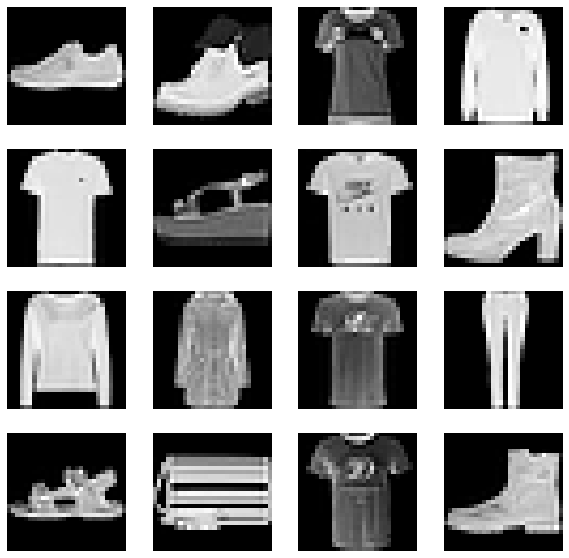

In [3]:
# Visualization of the original data.

fig = plt.figure(figsize=(10,10))

for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(X_dev[i,:].reshape(28,28), 'gray')
    ax.axis('off')

## Part 2: Automatic batch generator

We want you to create an automatic image generator that does several kinds of data augmentations, and produces a batch of data consisting of random samples every time you call it. 

<span style="color:red">__TODO__:</span> Finish the functions of class __ImageGenerator__ in __utils/image_generator.py__. The code is fully commented with instructions.

__Hint__: The python keywords __yield__ and __next__ can help you do some tricks.

In [4]:
from utils.image_generator import ImageGenerator

<span style="color:red">__TODO__:</span> Create an ImageGenerator object using the __development set__, and use __show__ function to plot the top 16 original images.

__Note__: You need to reshape your data as the demanding input format of the class __ImageGenerator__.

In [5]:
print(X_dev.shape)
print(X_dev.reshape(-1,1,28,28).transpose(0,2,3,1).shape)

(128, 784)
(128, 28, 28, 1)


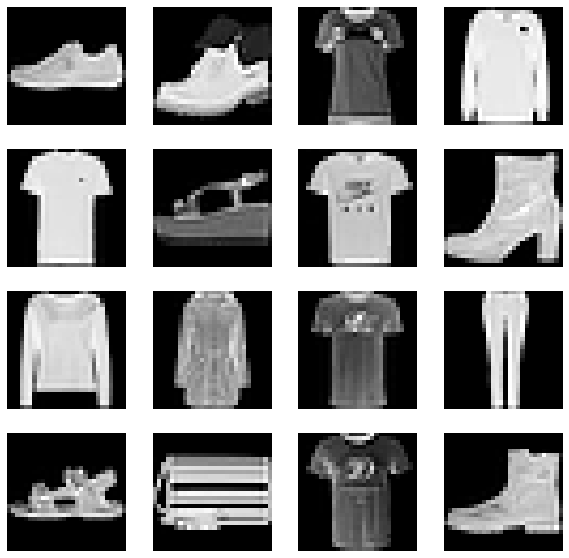

In [6]:
gen = ImageGenerator(X_dev.reshape(-1,1,28,28).transpose(0,2,3,1), y_dev)
# print(X_dev.shape)
gen.show(X_dev)

### Shift (demo)

Shift the original __development set__ by several pixels in both directions, and plot the top 16 images.

Current translation:  5 0


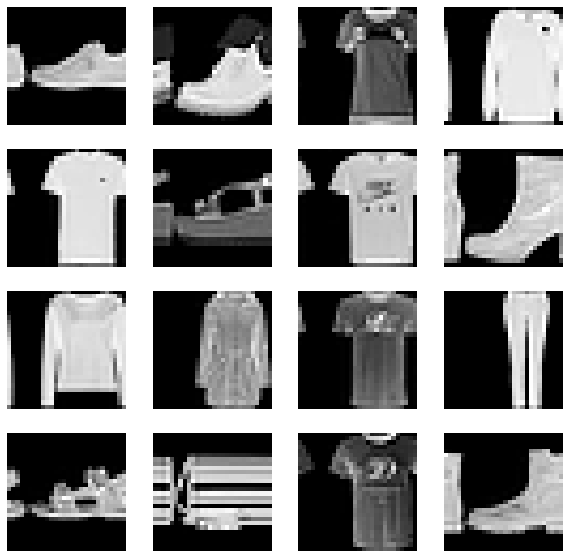

In [7]:
translated = gen.translate(5,0)
gen.show(translated)

### Rotation (demo)

Rotate the original __development set__ by several degrees, and plot the top 16 images. 

Currrent rotation:  30


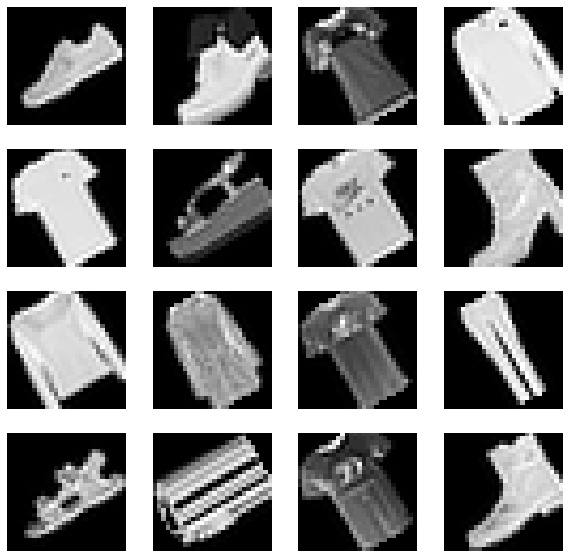

In [8]:
rotated = gen.rotate(30)
gen.show(rotated)

### Flipping (horizontal and vertical)

<span style="color:red">__TODO:__</span> Flip the original __development set__ as you like (horizontal, vertical, or both), and plot the top 16 images like you just did. 

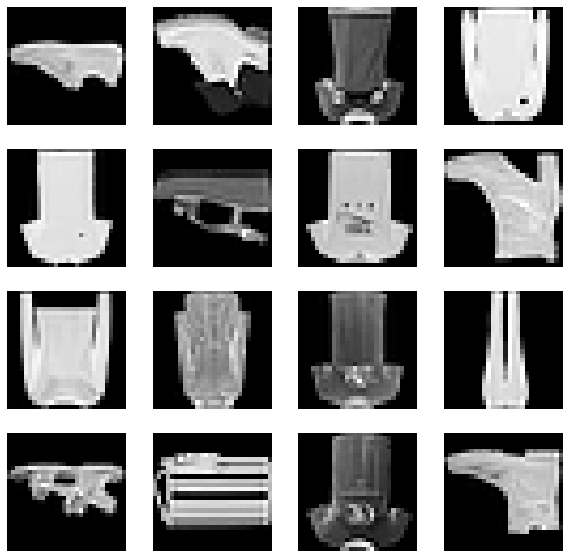

In [9]:
# YOUR CODE HERE
flip=gen.flip(mode='hv')
gen.show(flip)

### Add Noise

<span style="color:red">__TODO:__</span> Inject random noise into the original __development set__, and plot 16 images with noise added.(These images may not be the same as the above 16 images according to your choice of parameters.)

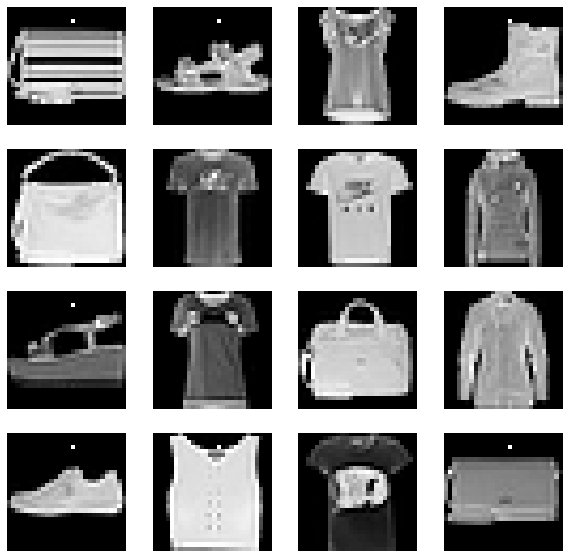

In [10]:
# YOUR CODE HERE
noisy=gen.add_noise(0.2,1)
gen.show(noisy)

## Part 3: Data Augmentation + LeNet

<span style="color:red">__TODO__:</span> Now that you have your own data generator. At the end of __utils/neuralnets/cnn/my_LeNet_model.py__, there is a not-implemented function __my_training_task4()__. Copy the __my_training()__ function above and modify it so that it uses your data generator for training. Train the network again - whether you see and improvement or a drop, record it and analyze why.

In [11]:
X_t = X_train.reshape(-1,1,28,28).transpose(0,2,3,1)
X_v = X_val.reshape(-1,1,28,28).transpose(0,2,3,1)

print(X_t.shape)
print(X_v.shape)

(59000, 28, 28, 1)
(1000, 28, 28, 1)


In [12]:
from utils.neuralnets.cnn.my_LeNet_model import my_training_task4
tf.reset_default_graph()
my_training_task4(X_train, y_train, X_val, y_val, conv_featmap=[6,8],fc_units=[100],
                      conv_kernel_size=[3,3],pooling_size=[2,2],conv_stride=[1,1],
                      l2_norm=0.01,seed=235,learning_rate=1e-3,epoch=20,batch_size=295,
                      verbose=False,pre_trained_model=None)

ValueError: not enough values to unpack (expected 4, got 2)

## Part 4 (demos): Transfer Learning and Test Time Augmentation (TTA)

This is the last part of assignment 2 before we go to the kaggle competition. In this part, we will provide you with examples of transfer learning, as well as the last context of data augmentation: test time augmentation. We believe they are useful tools for task 5. The following codes can run on Tensorflow 1.13. Please run it by yourself and get familiar with it.

__Note__: The network in demos is not guaranteed to be well-trained. __No points are set in this part__. Feel free to edit the scripts and tune the parameters by yourselves.

### Transfer Learning

The key reference is one official tutorial newly included in TensorFlow 2.0 Beta, we've changed it to fit for the version 1.13. For those of you who are curious about TF 2.0, you can also open the following link and try to run the code in 2.0 version. __But TF 2.0 is not allowed to use in our task5 kaggle competition__.

https://www.tensorflow.org/beta/tutorials/images/transfer_learning


The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. Generally, we have two ways to customize a pre-trained model:

1. **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for our dataset. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained. That means you do not need to (re)train the entire model. You "freeze" the base convolution network, and only train the newly added classifier layers. 

2. **Fine-Tuning**: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

This example uses the base model from the __MobileNet__ for a transfer learning of a 10-class classification task on CIFAR-10 dataset. The whole pipeline will include:

1. Load data
2. Build an input pipeline, in this case using Keras ImageDataGenerator
3. Compose our model
4. Load in our pretrained base model (and pretrained weights)
5. Stack our classification layers on top
6. Train our model
7. Evaluate model

Other references: https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e

In [13]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from utils.cifar_utils import load_data

In [14]:
import numpy as np
# Load the raw CIFAR-10 data.
X_train, y_train = load_data(mode='train')

print(X_train.shape)
# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# print(X_train)
# print(len(X_train))
# print(X_train[0].shape)

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)

./data/cifar-10-python.tar.gz already exists. Begin extracting...
(50000, 3072)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)


In [15]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [17]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [18]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [19]:
bs = 98 #batch size
epc = 25 #number of epoches
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator = train_datagen.flow(X_train, y_train_dummy, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [20]:
# train the model
history = model.fit_generator(generator = train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = epc,
                   validation_data=(X_val, y_val_dummy))

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
500/500 [==============================] - 48s 96ms/step - loss: 1.4452 - acc: 0.4933 - val_loss: 2.1451 - val_acc: 0.2840
Epoch 2/25
500/500 [==============================] - 25s 50ms/step - loss: 1.1540 - acc: 0.6046 - val_loss: 2.0735 - val_acc: 0.3600
Epoch 3/25
500/500 [==============================] - 25s 51ms/step - loss: 1.0337 - acc: 0.6480 - val_loss: 2.2894 - val_acc: 0.3550
Epoch 4/25
500/500 [==============================] - 25s 51ms/step - loss: 0.9459 - acc: 0.6789 - val_loss: 2.3249 - val_acc: 0.3410
Epoch 5/25
500/500 [==============================] - 25s 51ms/step - loss: 0.8765 - acc: 0.7019 - val_loss: 2.6767 - val_acc: 0.3190
Epoch 6/25
500/500 [==============================] - 25s 51ms/step - loss: 0.8217 - acc: 0.7221 - val_loss: 2.8453 - val_acc: 0.3440
Epoch 7/25
500/500 [==============================] - 26s 51ms/step - loss: 0.7652 - acc: 0.7413 - val_loss: 2.4070 - val_acc: 0.3540
Epoch 8/25
500

In [21]:
print(f'Baseline accuracy: {model.evaluate(X_val, y_val_dummy)[1]}')

1000/1000 [==============================] - 0s 492us/sample - loss: 3.6123 - acc: 0.3730
Baseline accuracy: 0.37299999594688416


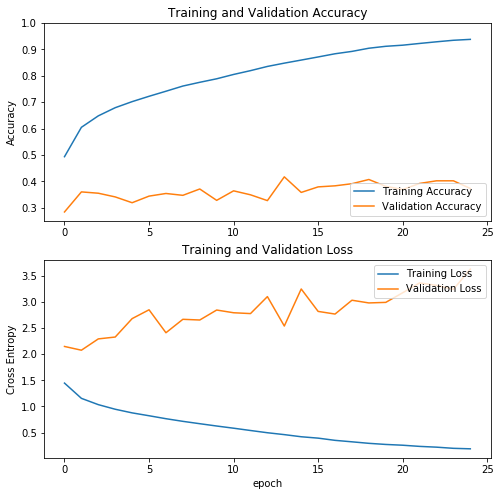

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Test Time Augmentation (TTA)

Key references: 

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

https://machinelearningmastery.com/how-to-use-test-time-augmentation-to-improve-model-performance-for-image-classification/


Data Augmentation is the process of randomly applying some operations (rotation, zoom, shift, flips,…) to the input data. By this mean, the model can learn more general features about the classes it has to recognize.

However, there also exists some ways to improve the results of the model by changing the way we test it. That is Test Time Augmentation (TTA).

TTA is now a commonly used technique in kaggle competition on classification. Similar to what data augmentation is doing to the training set, TTA is to perform similar data modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. The final guess of each corresponding image will base on the average of the prediction results.

The reason why we refer to TTA is that, by averaging our predictions, on randomly modified images, we are also averaging the errors. The error can be big in a single vector, leading to a wrong answer, but when averaged, only the correct answer stand out. TTA is particularly useful for test images that the model is pretty unsure. The following example will show you how to apply TTA with Keras.


#### Requirement:

__Install tqdm__: tqdm is a fast, extensible progress meter.

`pip install tqdm`

In [25]:
pip install tqdm

     |████████████████████████████████| 61kB 2.0MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [26]:
# call an ImageDataGenerator similar to training set for test set.
test_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [27]:
from tqdm import tqdm

# test time augmentation, we set TTA for 10 times averaging.
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(test_datagen.flow(X_val, batch_size=bs, shuffle=False), steps = len(X_val)/bs)
    predictions.append(preds)

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


In [28]:
# print final prediction results
final_pred = np.mean(predictions, axis=0)
print(f'Accuracy with TTA: {np.mean(np.equal(np.argmax(y_val_dummy, axis=-1), np.argmax(final_pred, axis=-1)))}')

Accuracy with TTA: 0.367
